# More EDA

Let's carry on from the last notebook, doing a preliminary investigation of the columns and potentially applying data fixes/filters that will be required prior to modeling 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import json
import pandas as pd
import altair as alt
import seaborn as sns
from terra_mystica_models.features import parse_interim
from terra_mystica_models.data.make_dataset import TerraMysticaGame

In [3]:
pd.options.display.max_rows = 999

In [4]:
alt.renderers.enable("jupyterlab")

RendererRegistry.enable('jupyterlab')

In [5]:
all_games_df = parse_interim.interim_full_pipe()

### Scoring tile columns

Last notebook I got caught up on the two games without scoring tiles and forgot to actually analyse their distribution

In [6]:
score_cols = [
        col
        for col in all_games_df.columns
        if col.startswith("score_turn")
]
all_scores = (
    all_games_df
    .melt(value_vars=score_cols)
    ["value"]
    .value_counts()
    .sort_values()
    .to_frame()
    .reset_index()
    .rename(columns={"index": "score_tile", "value": "count"})
)
all_scores

,score_tile,count
0,1 CULT_P -> 2 C | TE >> 4,58617
1,1 EARTH -> 1 C | SPADE >> 2,88284
2,4 WATER -> 1 SPADE | TP >> 3,102618
3,4 EARTH -> 1 SPADE | TOWN >> 5,103001
4,4 FIRE -> 4 PW | D >> 2,103020
5,2 FIRE -> 1 W | SA/SH >> 5,103020
6,4 AIR -> 1 SPADE | TP >> 3,103251
7,2 AIR -> 1 W | SA/SH >> 5,103311
8,4 WATER -> 1 P | D >> 2,103378


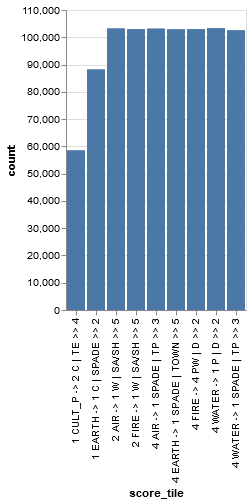

In [7]:
alt.Chart(all_scores).mark_bar().encode(x="score_tile", y="count")

OK, again we have a pretty nice even distribution except for a couple tiles. Maybe expansions?

## Victory points.
Ok, this is where it all goes down. I want to analyze individual player stats before I get to feature engineering but let's finish off the basic game stats before moving on to that.

### Overall VP distribution

I'm also going to stagger this by player order to see if there's a positional advantage, but let's just see what the general distribution of points and point margins is.

I'm going to switch to seaborn for distributional plotting. Altair will embed every data point that goes into the data visualization and blow up the size of my notebook (learned the hard way on an earlier project)

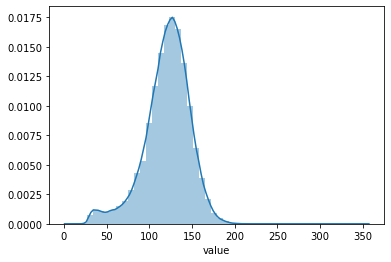

In [8]:
vp_cols = [col for col in all_games_df.columns if col.endswith("vp")]
all_vps = (
    all_games_df
    .reset_index()
    .melt(value_vars=vp_cols)
    .dropna()
    ["value"]
)
sns.distplot(all_vps);

Ok, we have a weird left tail of low scoring games - maybe premature finishes or high player count? Can investigate more later. Overall It's a pretty symmetric distribution looking centered in the neighborhood of 125. I'll repeat this analysis on the subset of games that I actually want to model later and I'll be particularly interested in what happens with that left tail. Let's get a numerical summary of this same data

In [9]:
all_vps.describe()

count    517413.000000
mean        120.648841
std          26.748005
min           6.000000
25%         107.000000
50%         123.000000
75%         138.000000
max         352.000000
Name: value, dtype: float64

Ok, so there's a very fat tail out to the right that was hard to see on the chart as well. would be interesting to see what happened with that game with 352 VP. Let's track that down

In [10]:
mask = (all_games_df[vp_cols] == 352).any(axis="columns")
all_games_df.loc[mask].T

,MtLHiScoreEng1
date,2017-06-24 21:07:08
map,126fe960806d587c78546b30f1a90853b1ada468
number_of_players,5
original_map,True
has_expansion_factions,False
has_dropped_faction,False
file,2017-06.json
score_turn_1,1 CULT_P -> 2 C | TE >> 4
score_turn_2,4 FIRE -> 4 PW | D >> 2
score_turn_3,4 WATER -> 1 SPADE | TP >> 3


Ok, so this is just some dude playing against himself specifically to get a high score. That brings up a good thing to filter for, I probably don't want games without unique users. Will have to code for that carefully so I don't accidentally drop games with an "Other" player or something

Since that so quickly identified a data concern let's take a look at the 6 point game and see what's up with it

In [11]:
mask = (all_games_df[vp_cols] == 6).any(axis="columns")
all_games_df.loc[mask].T

,Moon29
date,2016-08-20 11:04:55
map,126fe960806d587c78546b30f1a90853b1ada468
number_of_players,5
original_map,True
has_expansion_factions,True
has_dropped_faction,False
file,2016-08.json
score_turn_1,4 WATER -> 1 P | D >> 2
score_turn_2,4 WATER -> 1 SPADE | TP >> 3
score_turn_3,4 AIR -> 1 SPADE | TP >> 3


Interesting, less obvious what happened there. I'd have guessed the 5th player quit early but "has_dropped_faction" is False, which I thought accounted for that. OK, I don't know what to do with that right now, will just have to keep it in mind.

### VP margin distribution

Let's take a look at how much people are winning by

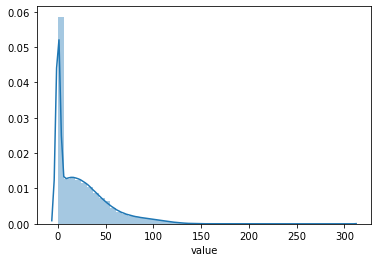

In [12]:
vp_margin_cols = [col for col in all_games_df.columns if col.endswith("vp_margin")]
all_vp_margins = (
    all_games_df
    .reset_index()
    .melt(value_vars=vp_margin_cols)
    .dropna()
    ["value"]
)
sns.distplot(all_vp_margins);

In [13]:
all_vp_margins.describe()

count    517413.000000
mean         25.071738
std          27.805489
min           0.000000
25%           0.000000
50%          17.000000
75%          39.000000
max         306.000000
Name: value, dtype: float64

Oh, wait. I'm dumb. I got all concerned about how many 0s there are, but *by design* there's at least one zero in every game, since I calcuate the margin as how far above the lowest scoring player you are.

Still, that distribution might be trouble for modelling. It might be safer to model total victory points. Either way we're just interested in the faction choice that gives you a marginal point advantage given your known parameters

It would be interesting to see how many ties for first there are though.

In [14]:
# I don't need to redefine this but having it here makes it easier to follow the code
# Although I'm immediately writing some pretty ugly code right below it so....
vp_cols = [col for col in all_games_df.columns if col.endswith("vp")]
vp_testing_df = (
    all_games_df
    .reindex(columns=vp_cols)
    .assign(winning_vp=lambda df: df[vp_cols].max(axis="columns"))
)
tie_test_cols = []
for player_num in range(1, 8):
    player_col = f"player_{player_num}_vp"
    calc_col = f"player_{player_num}_has_high_score"
    tie_test_cols.append(calc_col)
    vp_testing_df[calc_col] = vp_testing_df[player_col] == vp_testing_df["winning_vp"]
vp_testing_df["winning_vp_count"] = vp_testing_df[tie_test_cols].sum(axis="columns")
num_winners = vp_testing_df["winning_vp_count"]
num_winners.describe()

count    144750.000000
mean          1.024636
std           0.157488
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           4.000000
Name: winning_vp_count, dtype: float64

Ok, excellent. It looks like there's almost always a winner. That four way tie might be fun to check out though

In [15]:
vp_testing_df.loc[vp_testing_df["winning_vp_count"] == 4].index

Index(['4pLeague_S34_D6L1_G7'], dtype='object')

In [16]:
all_games_df.loc["4pLeague_S34_D6L1_G7"].T

date                                           2020-01-10 21:57:09
map                       126fe960806d587c78546b30f1a90853b1ada468
number_of_players                                                4
original_map                                                  True
has_expansion_factions                                       False
has_dropped_faction                                          False
file                                                  2020-01.json
score_turn_1                          4 WATER -> 1 SPADE | TP >> 3
score_turn_2                           1 EARTH -> 1 C | SPADE >> 2
score_turn_3                        4 EARTH -> 1 SPADE | TOWN >> 5
score_turn_4                             1 CULT_P -> 2 C | TE >> 4
score_turn_5                               4 WATER -> 1 P | D >> 2
score_turn_6                            2 FIRE -> 1 W | SA/SH >> 5
BON1                                                          True
BON2                                                          

Oh very interesting. All real players, judging by the index this is some sort of semi pro game and by the looks of it it's a legit 4 way tie. That's cool!

## Players

That's actually a perfect transition to looking at the players

First quick step is to take a look at just first player users so I can understand how anonymous users are encoded

In [17]:
user_cols = sorted([col for col in all_games_df.columns if col.endswith("user")])
mask = all_games_df["player_1_user"].isna()
all_games_df.loc[mask, user_cols].head(10)

,player_1_user,player_2_user,player_3_user,player_4_user,player_5_user,player_6_user,player_7_user
pbc3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gareth4,NaN,McRegnak,jsnell,Lachlan,NaN,NaN,NaN
gareth5,NaN,lode,Jan,Pri,Tobulogic,NaN,NaN
gareth6,NaN,menderico,NaN,giorgio.ugazio,magnusrk,NaN,NaN
pbc1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pbc2,NaN,NaN,NaN,NaN,NaN,NaN,NaN


That's too bad. Ok, let's find an "Anonymous" user string that I can use that won't conflict with an actual user name

In [18]:
anon_name = "Anonymous Terra Mystica User" # I bet spaces aren't allowed in real user names
assert not (all_games_df[user_cols] == anon_name).any().any() #check by columns and index

In [19]:
for player_num in range(1, 8):
    user_col = f"player_{player_num}_user"
    mask = all_games_df["number_of_players"] >= player_num # only fill in for games that actually have that many players
    all_games_df.loc[mask, user_col] = all_games_df.loc[mask, user_col].fillna(anon_name)

In [20]:
user_cols = sorted([col for col in all_games_df.columns if col.endswith("user")])
mask = all_games_df["player_1_user"].isna()
all_games_df.loc[mask, user_cols].head(10)

,player_1_user,player_2_user,player_3_user,player_4_user,player_5_user,player_6_user,player_7_user


Ok that seems to have worked. I'll refactor that out into a function later

In [21]:
# This should probably get turned into a function
user_cols = [col for col in all_games_df.columns if col.endswith("user")]
player_df = (
    all_games_df
    .melt(value_vars=user_cols)
    ["value"]
    .dropna()
    .value_counts()
)
player_df

hanktank         3065
strongpoet       1828
Fiitsch          1431
OrionHegenomy    1367
mcd13            1160
                 ... 
projectzacra        1
Kinrove             1
Reini787            1
pinkseachut         1
Thorgrimm           1
Name: value, Length: 11957, dtype: int64

In [22]:
player_df.loc[anon_name]

306

Interesting, most people are playing with a username, even if they're only playing one game

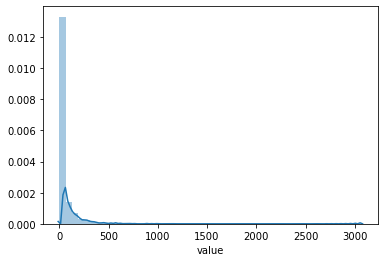

In [23]:
sns.distplot(player_df);

Yeah, huge spike at 1 game and then a very long tail. hanktank has played an insane number of games.

### Clean way to do player stats

Basically I want a way to account for, or at least look at the stats of users that have a lot of games under their belts relative to everyone else. 
As a first cut I think I'll treat anonymous players the same as players that have a very small number of games. I'm going to reload the game dataframe here because I want to turn this into a reproducible function to add these stats in after I've played around with it a bit

In [24]:
all_games_df = parse_interim.interim_full_pipe()
anon_name = "Other Terra Mystica User" # I bet spaces aren't allowed in real user names
assert not (all_games_df[user_cols] == anon_name).any().any() #check by columns and index
for player_num in range(1, 8):
    user_col = f"player_{player_num}_user"
    mask = all_games_df["number_of_players"] >= player_num # only fill in for games that actually have that many players
    all_games_df.loc[mask, user_col] = all_games_df.loc[mask, user_col].fillna(anon_name)

In [25]:
all_games_df[["number_of_players"] + user_cols]

,number_of_players,player_1_user,player_2_user,player_3_user,player_4_user,player_5_user,player_6_user,player_7_user
pbc3,3,Other Terra Mystica User,Other Terra Mystica User,Other Terra Mystica User,NaN,NaN,NaN,NaN
10,4,Other Terra Mystica User,Other Terra Mystica User,Other Terra Mystica User,Other Terra Mystica User,NaN,NaN,NaN
21,4,dkeisen,jsnell,Jan,Other Terra Mystica User,NaN,NaN,NaN
5,4,Other Terra Mystica User,Other Terra Mystica User,Other Terra Mystica User,Other Terra Mystica User,NaN,NaN,NaN
8,5,Other Terra Mystica User,Other Terra Mystica User,Other Terra Mystica User,Other Terra Mystica User,Other Terra Mystica User,NaN,NaN
...,...,...,...,...,...,...,...,...
ZGame301,4,ZeroCool2017,Romeister,r_ikiri,darreius,NaN,NaN,NaN
ZGame302,4,Weltmann,GilbertBourdin,Fironics,ZeroCool2017,NaN,NaN,NaN
ZGame303,4,Weltmann,GilbertBourdin,Fironics,ZeroCool2017,NaN,NaN,NaN
ZGame304,4,Snitz,zizzus,ZeroCool2017,Cthulhu,NaN,NaN,NaN


In [26]:
# This should probably get turned into a function
user_cols = [col for col in all_games_df.columns if col.endswith("user")]
user_game_count = (
    all_games_df
    .melt(value_vars=user_cols)
    ["value"]
    .dropna()
    .value_counts()
    .drop(anon_name)
)
user_game_count

hanktank         3065
strongpoet       1828
Fiitsch          1431
OrionHegenomy    1367
mcd13            1160
                 ... 
projectzacra        1
Kinrove             1
Reini787            1
pinkseachut         1
Thorgrimm           1
Name: value, Length: 11956, dtype: int64

Using a fun statistics rule of thumb let's say we can compute meaningful stats for anyone with at least 30 games. How many users does that get us?

In [27]:
len(user_game_count.loc[user_game_count >= 30])

3458

Ok, not bad. Still lots of users, but we've trimmed out the anonymous ones. Let's figure out how to compute some summary stats for these players and then attach it to the base dataframe

In [28]:
rankable_users = user_game_count.loc[user_game_count >= 30].index

In [29]:
for player_num in range(1, 8):
    user_col = f"player_{player_num}_user"
    mask = (
        (~(all_games_df[user_col].isin(rankable_users)))
        & (all_games_df["number_of_players"] >= player_num)
    )
    all_games_df.loc[mask, user_col] = anon_name

In [30]:
all_games_df[["number_of_players"] + user_cols]

,number_of_players,player_1_user,player_2_user,player_3_user,player_4_user,player_5_user,player_6_user,player_7_user
pbc3,3,Other Terra Mystica User,Other Terra Mystica User,Other Terra Mystica User,NaN,NaN,NaN,NaN
10,4,Other Terra Mystica User,Other Terra Mystica User,Other Terra Mystica User,Other Terra Mystica User,NaN,NaN,NaN
21,4,Other Terra Mystica User,jsnell,Jan,Other Terra Mystica User,NaN,NaN,NaN
5,4,Other Terra Mystica User,Other Terra Mystica User,Other Terra Mystica User,Other Terra Mystica User,NaN,NaN,NaN
8,5,Other Terra Mystica User,Other Terra Mystica User,Other Terra Mystica User,Other Terra Mystica User,Other Terra Mystica User,NaN,NaN
...,...,...,...,...,...,...,...,...
ZGame301,4,ZeroCool2017,Romeister,r_ikiri,darreius,NaN,NaN,NaN
ZGame302,4,Weltmann,GilbertBourdin,Fironics,ZeroCool2017,NaN,NaN,NaN
ZGame303,4,Weltmann,GilbertBourdin,Fironics,ZeroCool2017,NaN,NaN,NaN
ZGame304,4,Snitz,zizzus,ZeroCool2017,Cthulhu,NaN,NaN,NaN


Ok that worked, now I need to combine these with their VP and VP margin across player order

In [31]:
# This seems inefficient but it should work, so that's nice
def player_num_stats(player_num):
    user_col = f"player_{player_num}_user"
    vp_col = f"player_{player_num}_vp"
    margin_col = f"player_{player_num}_vp_margin"
    player_df = (
        all_games_df
        .loc[all_games_df["number_of_players"] >= player_num]
        .reindex(columns=[user_col, vp_col, margin_col])
        .rename(columns={user_col: "user", vp_col: "vp", margin_col: "vp_margin"})
    )
    return player_df

full_player_df = (
    pd.concat([player_num_stats(player_num) for player_num in range(1, 8)])
    .reset_index()
    .groupby("user")
    .agg({"index": "count", "vp": "mean", "vp_margin": "mean"})
    .rename(columns={"index": "number_of_games", "vp": "mean_vp", "vp_margin": "mean_vp_margin"})
)
full_player_df.sort_values(by="number_of_games")

,number_of_games,mean_vp,mean_vp_margin
user,,,
Yor,30,124.200000,36.866667
coachbam,30,114.266667,44.400000
CO2,30,101.433333,6.933333
DerMahler,30,106.466667,22.466667
VMuniz,30,112.366667,32.866667
...,...,...,...
OrionHegenomy,1367,143.977323,24.694221
Fiitsch,1431,137.657582,20.037037
strongpoet,1828,149.145514,14.137309


Ok sweet. I can refactor that into a function and use it to attach player number stats to a dataframe. I'll want to do that part carefully when actually training the model so that games I'm trying to predict don't leak information into games I'm training on. Let's finish up here by looking at some user level distributions

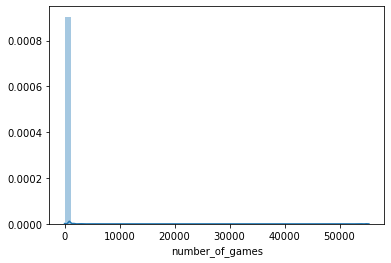

In [32]:
sns.distplot(full_player_df["number_of_games"]);

In [33]:
full_player_df["number_of_games"].describe()

count     3459.000000
mean       149.583406
std        949.148090
min         30.000000
25%         49.000000
50%         85.000000
75%        162.000000
max      55283.000000
Name: number_of_games, dtype: float64

Yeah, not much to see there, most people cluster on the low end which is not surprising

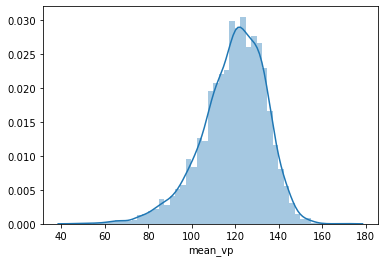

In [34]:
sns.distplot(full_player_df["mean_vp"]);

In [35]:
full_player_df["mean_vp"].describe()

count    3459.000000
mean      119.137581
std        14.693907
min        47.250000
25%       110.690598
50%       120.791667
75%       129.656478
max       169.812500
Name: mean_vp, dtype: float64

Interesting, there's a few players who really suck. Most are right around the overall population average we calculated above, and there's a relatively sharp drop off for players that consistently score high

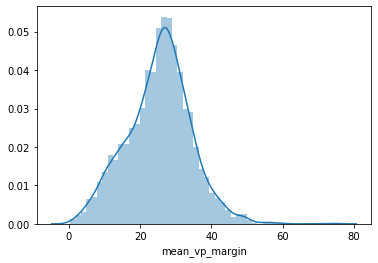

In [36]:
sns.distplot(full_player_df["mean_vp_margin"]);

In [37]:
full_player_df["mean_vp_margin"].describe()

count    3459.000000
mean       25.265732
std         9.069008
min         0.339623
25%        19.617333
50%        25.883333
75%        30.859353
max        75.459459
Name: mean_vp_margin, dtype: float64

Again, we've got a small number of players that seem to average quite close to dead last, most are right around the overall population average, and then there's a small cluster that really crush it.

OK, that's enough for now. Next notebook we'll filter down to the particular population we're actually interested in modelling (4 player games on the base map without expansions) and start doing some comparative statistics